# Training Notebook

Training on Mixed and UT-West-Campus datasets. Evaluate on test portion of both

Train Mask-RCNN + ResNet101 Backbone

Add a couple additional things: 
- Validation Loop using loss 
- Checkpoint based off of best validation metrics
- Custom COCO Style Dataloaders

In [1]:
# python libraries
import os
import json
import random
import math
import time
import datetime
import logging
from glob import glob

import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

# d2 libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils import comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import EvalHook, BestCheckpointer
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    get_detection_dataset_dicts,
    DatasetMapper,
)
import detectron2.data.transforms as T
from detectron2.utils.logger import setup_logger

# my stuff
from data_utils import (
    read_split_file,
    register_dataset,
    random_split_mixed_set,
    random_split_ut_west_campus_set
)

# setup D2 logger
setup_logger()

%matplotlib inline

### Randomly Split Mixed Dataset

For reproducibility we seed the shuffler with the value 10

In [2]:
mixed_datasets = read_split_file("data/missed_detections/mixed/split.txt")

### Randomly Split UT-West-Campus Dataset

In [3]:
ut_west_campus_datasets = read_split_file("data/missed_detections/ut_west_campus/split.txt")

### Register Mixed Dataset Splits

In [4]:
classes = ["label", "button"]
colors = [(0, 255, 0), (0, 0, 255)]

dataset_names = [
    "mixed_train",
    "mixed_val",
    "mixed_test",
    "ut_west_campus_train",
    "ut_west_campus_val",
    "ut_west_campus_test",
]

# register combined training and validation sets
for name, im_paths in zip(dataset_names, mixed_datasets + ut_west_campus_datasets):
    DatasetCatalog.register(
        name=name, func=lambda im_paths=im_paths: register_dataset(im_paths=im_paths)
    )
    MetadataCatalog.get(name=name).set(thing_classes=classes, thing_colors=colors)

elevator_metadata = MetadataCatalog.get("mixed_train")

In [5]:
mixed_train = DatasetCatalog.get("mixed_train")
ut_west_campus_train = DatasetCatalog.get("ut_west_campus_train")
trainset = mixed_train + ut_west_campus_train
print("total trainset len: ", len(trainset))

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7638/7638 [13:03<00:00,  9.75it/s]

total trainset len:  10931


### Visualize Training Data Samples

Ensure that data is annotated correctly

data/missed_detections/ut_west_campus/norman_hackerman_6_20.jpg


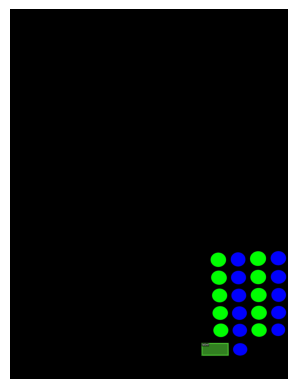

data/missed_detections/ut_west_campus/texas_union-2_0_13.jpg


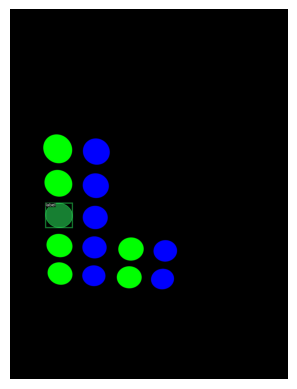

data/missed_detections/ut_west_campus/pma_13_64.jpg


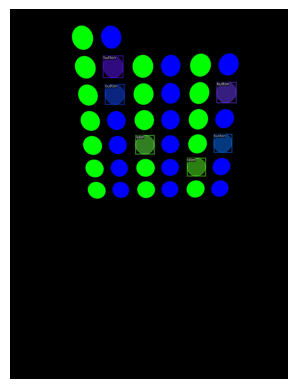

data/missed_detections/ut_west_campus/ecj_1_32.jpg


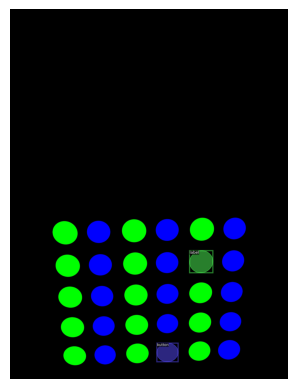

data/missed_detections/ut_west_campus/ecj_16_3.jpg


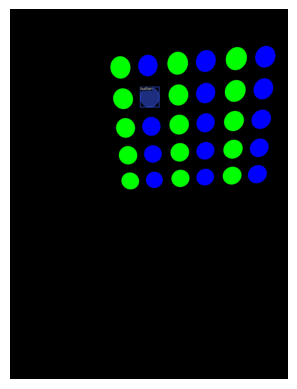

In [6]:
for d in random.sample(trainset, 5):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=elevator_metadata,
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Validation Loop using Validation Loss

as opposed to evaluation metrics (AP, Precision, Recall, etc.)

In [7]:
def validation_loop(model: torch.nn, dataloader: torch.utils.data.DataLoader) -> dict:
    """
    Validate model on the given dataloader. Put model in training mode to output loss
    dict but do not backpropogate gradients. Largely adapted from train_loop.py and
    inference_on_dataset

    Args:
        model (torch.nn): model to validate
        dataloader (torch.utils.data.DataLoader): validation dataloader set to training
            mode

    Returns:
        dict: {"validation_loss": val_loss}
    """
    model.train()
    num_batches = len(dataloader)
    num_warmup = min(5, num_batches - 1)
    start_time = time.perf_counter()
    total_compute_time = 0
    losses = []
    for idx, data in enumerate(dataloader):
        if idx == num_warmup:
            start_time = time.perf_counter()
            total_compute_time = 0
        start_compute_time = time.perf_counter()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        total_compute_time += time.perf_counter() - start_compute_time
        iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
        seconds_per_img = total_compute_time / iters_after_start
        if idx >= num_warmup * 2 or seconds_per_img > 5:
            total_seconds_per_img = (
                time.perf_counter() - start_time
            ) / iters_after_start
            eta = datetime.timedelta(
                seconds=int(total_seconds_per_img) * (num_batches - idx - 1)
            )
            log_every_n_seconds(
                logging.INFO,
                "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                    idx + 1, num_batches, seconds_per_img, str(eta)
                ),
                n=5,
            )

        batch_loss_dict = model(data)
        batch_loss_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in batch_loss_dict.items()
        }
        total_batch_loss = sum(loss for loss in batch_loss_dict.values())
        losses.append(total_batch_loss)
    val_loss = np.mean(losses)
    comm.synchronize()
    log_every_n_seconds(logging.INFO, f"VALIDATION_LOSS: {val_loss:.5f}")
    return {"validation_loss": val_loss}

### Define a Custom Trainer

Add custom hooks and dataloaders

In [8]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_validation_loader(cls, cfg):
        return build_detection_test_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.VAL, filter_empty=False
            ),
            mapper=DatasetMapper(
                cfg,
                is_train=True,
                image_format="BGR",
                use_instance_mask=True,
            ),
        )

    def build_hooks(self) -> list:
        """
        Overwrite the evaluation loop and checkpoint using best validation loss

        Returns:
            list: list of hooks
        """
        hooks = super().build_hooks()
        # remove existing EvalHook
        if comm.is_main_process():
            del hooks[-2]
            del hooks[-2]
        else:
            del hooks[-1]
        hooks.extend(
            [
                EvalHook(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    eval_function=lambda: validation_loop(
                        self.model,
                        self.build_validation_loader(self.cfg),
                    ),
                    eval_after_train=True,
                ),
                BestCheckpointer(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    checkpointer=self.checkpointer,
                    val_metric="validation_loss",
                    mode="min",
                ),
            ]
        )
        return hooks

### Define Config for Building Model

Use Mask-RCNN w/ ResNet-101 Backbone

In [9]:
mask_rcnn_res50 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mask_rcnn_res101 = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
cascade_mask_rcnn_res50 = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"

base_cfg = mask_rcnn_res101

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(base_cfg))

# start from pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_cfg)

# assign datasets and adjust ROI HEADS to match num classes
cfg.DATASETS.TRAIN = ("mixed_train", "ut_west_campus_train")
cfg.DATASETS.VAL = ("mixed_val", "ut_west_campus_val")
cfg.DATASETS.TEST = ("mixed_test", "ut_west_campus_test")
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
cfg.MODEL.DEVICE = "cuda:1"

# Calculate training logic
epochs = 30
batch_size = 32
eval_period = 2
iters_per_epoch = math.ceil(len(trainset) / batch_size)

cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * eval_period
cfg.SOLVER.BASE_LR = 3e-5
cfg.SOLVER.STEPS = [int(0.7 * cfg.SOLVER.MAX_ITER), int(0.8 * cfg.SOLVER.MAX_ITER)]
cfg.SOLVER.WARMUP_ITERS = int(0.067 * cfg.SOLVER.MAX_ITER)

# SAVE DIR
cfg.OUTPUT_DIR = "./models/recovery_resnet"

### Train Configured Model

Use modified DefaultTrainer

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/26 13:49:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7638/7638 [11:49<00:00, 10.77it/s]

[02/26 14:02:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 14:02:10 d2.data.build]: Using training sampler TrainingSampler


[02/26 14:02:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 14:02:10 d2.data.common]: Serializing 10931 elements to byte tensors and concatenating them all ...
[02/26 14:02:27 d2.data.common]: Serialized dataset takes 250.27 MiB
[02/26 14:02:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/26 14:02:28 d2.engine.train_loop]: Starting training from iteration 0


/scratch/cluster/abhinavc/miniforge3/envs/d2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/26 14:03:42 d2.utils.events]:  eta: 10:08:25  iter: 19  total_loss: 2.46  loss_cls: 1.255  loss_box_reg: 0.001049  loss_mask: 0.6924  loss_rpn_cls: 0.4735  loss_rpn_loc: 0.02804  time: 3.3471  last_time: 3.6167  data_time: 1.8867  last_data_time: 2.1310   lr: 8.5886e-07  max_mem: 0M
[02/26 14:04:45 d2.utils.events]:  eta: 9:38:19  iter: 39  total_loss: 2.481  loss_cls: 1.197  loss_box_reg: 0.003025  loss_mask: 0.6918  loss_rpn_cls: 0.549  loss_rpn_loc: 0.03544  time: 3.2367  last_time: 3.2829  data_time: 1.6823  last_data_time: 1.8149   lr: 1.7314e-06  max_mem: 0M
[02/26 14:05:52 d2.utils.events]:  eta: 9:39:31  iter: 59  total_loss: 2.314  loss_cls: 1.086  loss_box_reg: 0.002325  loss_mask: 0.6909  loss_rpn_cls: 0.4957  loss_rpn_loc: 0.03248  time: 3.2686  last_time: 3.4404  data_time: 1.8687  last_data_time: 2.1260   lr: 2.6038e-06  max_mem: 0M
[02/26 14:06:55 d2.utils.events]:  eta: 9:36:03  iter: 79  total_loss: 2.138  loss_cls: 0.9453  loss_box_reg: 0.002251  loss_mask: 0.6885

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [01:04<00:00,  9.63it/s]

[02/26 14:40:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 14:40:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 14:40:48 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 14:40:50 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 14:40:54 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:40:59 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:04 detectron2]: Loss on Validation  done 71/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:09 detectron2]: Loss on Validation  done 147/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:14 detectron2]: Loss on Validation  done 194/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:19 detectron2]: Loss on Validation  done 211/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:25 detectron2]: Loss on Validation  done 223/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:30 detectron2]: Loss on Validation  done 235/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:35 detectron2]: Loss on Validation  done 246/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:40 detectron2]: Loss on Validation  done 257/1270. 0.0000 s / img. ETA=0:00:00
[02/26 14:41:45

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:59<00:00, 10.43it/s]

[02/26 15:27:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 15:27:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 15:27:57 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 15:27:59 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 15:28:00 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:06 detectron2]: Loss on Validation  done 47/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:11 detectron2]: Loss on Validation  done 74/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:16 detectron2]: Loss on Validation  done 144/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:21 detectron2]: Loss on Validation  done 192/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:26 detectron2]: Loss on Validation  done 212/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:31 detectron2]: Loss on Validation  done 225/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:37 detectron2]: Loss on Validation  done 238/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:42 detectron2]: Loss on Validation  done 250/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:47 detectron2]: Loss on Validation  done 263/1270. 0.0000 s / img. ETA=0:00:00
[02/26 15:28:52

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.68it/s]


[02/26 16:13:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 16:13:08 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 16:13:08 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/26 16:13:10 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 16:13:11 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:13:16 detectron2]: Loss on Validation  done 47/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:13:21 detectron2]: Loss on Validation  done 71/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:13:26 detectron2]: Loss on Validation  done 138/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:13:32 detectron2]: Loss on Validation  done 187/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:13:37 detectron2]: Loss on Validation  done

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:58<00:00, 10.64it/s]

[02/26 16:58:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 16:58:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 16:58:23 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 16:58:25 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 16:58:26 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:31 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:36 detectron2]: Loss on Validation  done 66/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:41 detectron2]: Loss on Validation  done 137/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:46 detectron2]: Loss on Validation  done 186/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:52 detectron2]: Loss on Validation  done 207/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:58:57 detectron2]: Loss on Validation  done 218/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:59:02 detectron2]: Loss on Validation  done 229/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:59:07 detectron2]: Loss on Validation  done 241/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:59:12 detectron2]: Loss on Validation  done 252/1270. 0.0000 s / img. ETA=0:00:00
[02/26 16:59:17

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:58<00:00, 10.58it/s]


[02/26 17:44:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 17:44:21 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 17:44:21 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/26 17:44:23 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 17:44:24 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 17:44:29 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 17:44:34 detectron2]: Loss on Validation  done 66/1270. 0.0000 s / img. ETA=0:00:00
[02/26 17:44:39 detectron2]: Loss on Validation  done 131/1270. 0.0000 s / img. ETA=0:00:00
[02/26 17:44:44 detectron2]: Loss on Validation  done 183/1270. 0.0000 s / img. ETA=0:00:00
[02/26 17:44:50 detectron2]: Loss on Validation  done

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:58<00:00, 10.64it/s]

[02/26 18:30:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 18:30:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 18:30:42 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 18:30:44 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 18:30:45 detectron2]: Loss on Validation  done 11/1270. 0.0010 s / img. ETA=0:00:00
[02/26 18:30:51 detectron2]: Loss on Validation  done 46/1270. 0.0002 s / img. ETA=0:00:00
[02/26 18:30:56 detectron2]: Loss on Validation  done 62/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:01 detectron2]: Loss on Validation  done 112/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:06 detectron2]: Loss on Validation  done 174/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:11 detectron2]: Loss on Validation  done 202/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:16 detectron2]: Loss on Validation  done 214/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:21 detectron2]: Loss on Validation  done 224/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:27 detectron2]: Loss on Validation  done 234/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:32 detectron2]: Loss on Validation  done 245/1270. 0.0001 s / img. ETA=0:00:00
[02/26 18:31:37

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.71it/s]


[02/26 19:17:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 19:17:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 19:17:54 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/26 19:17:56 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 19:17:57 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 19:18:02 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 19:18:07 detectron2]: Loss on Validation  done 69/1270. 0.0000 s / img. ETA=0:00:00
[02/26 19:18:12 detectron2]: Loss on Validation  done 134/1270. 0.0000 s / img. ETA=0:00:00
[02/26 19:18:17 detectron2]: Loss on Validation  done 184/1270. 0.0000 s / img. ETA=0:00:00
[02/26 19:18:22 detectron2]: Loss on Validation  done

registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:58<00:00, 10.64it/s]

[02/26 20:03:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 20:03:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 20:03:49 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 20:03:52 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 20:03:52 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:03:58 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:03 detectron2]: Loss on Validation  done 66/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:08 detectron2]: Loss on Validation  done 132/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:13 detectron2]: Loss on Validation  done 186/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:18 detectron2]: Loss on Validation  done 207/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:23 detectron2]: Loss on Validation  done 219/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:29 detectron2]: Loss on Validation  done 231/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:34 detectron2]: Loss on Validation  done 242/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:39 detectron2]: Loss on Validation  done 253/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:04:44

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.76it/s]

[02/26 20:49:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]


[02/26 20:49:48 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 20:49:48 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/26 20:49:50 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 20:49:51 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:49:56 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:01 detectron2]: Loss on Validation  done 67/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:06 detectron2]: Loss on Validation  done 133/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:11 detectron2]: Loss on Validation  done 185/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:17 detectron2]: Loss on Validation  done 207/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:22 detectron2]: Loss on Validation  done 219/1270. 0.0000 s / img. ETA=0:00:00
[02/26 20:50:27 detectron2]: Loss on Validation  done 231/1270. 0.0

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:58<00:00, 10.52it/s]

[02/26 21:37:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 21:37:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 21:37:38 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 21:37:40 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 21:37:41 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:37:46 detectron2]: Loss on Validation  done 47/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:37:51 detectron2]: Loss on Validation  done 69/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:37:56 detectron2]: Loss on Validation  done 137/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:01 detectron2]: Loss on Validation  done 186/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:07 detectron2]: Loss on Validation  done 207/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:12 detectron2]: Loss on Validation  done 218/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:17 detectron2]: Loss on Validation  done 229/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:22 detectron2]: Loss on Validation  done 240/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:27 detectron2]: Loss on Validation  done 251/1270. 0.0000 s / img. ETA=0:00:00
[02/26 21:38:32

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.67it/s]

[02/26 22:24:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 22:24:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 22:24:03 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 22:24:05 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 22:24:06 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:11 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:16 detectron2]: Loss on Validation  done 68/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:21 detectron2]: Loss on Validation  done 141/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:26 detectron2]: Loss on Validation  done 190/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:32 detectron2]: Loss on Validation  done 209/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:37 detectron2]: Loss on Validation  done 220/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:42 detectron2]: Loss on Validation  done 231/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:47 detectron2]: Loss on Validation  done 242/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:52 detectron2]: Loss on Validation  done 253/1270. 0.0000 s / img. ETA=0:00:00
[02/26 22:24:57

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.72it/s]

[02/26 23:10:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/26 23:10:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 23:10:12 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...


[02/26 23:10:14 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 23:10:15 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:20 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:25 detectron2]: Loss on Validation  done 74/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:30 detectron2]: Loss on Validation  done 144/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:35 detectron2]: Loss on Validation  done 189/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:41 detectron2]: Loss on Validation  done 209/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:46 detectron2]: Loss on Validation  done 222/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:52 detectron2]: Loss on Validation  done 234/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:10:57 detectron2]: Loss on Validation  done 245/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:11:02 detectron2]: Loss on Validation  done 256/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:11:07

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.74it/s]

[02/26 23:56:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]


[02/26 23:56:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/26 23:56:14 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/26 23:56:16 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/26 23:56:17 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:22 detectron2]: Loss on Validation  done 47/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:27 detectron2]: Loss on Validation  done 71/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:32 detectron2]: Loss on Validation  done 138/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:37 detectron2]: Loss on Validation  done 186/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:42 detectron2]: Loss on Validation  done 207/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:47 detectron2]: Loss on Validation  done 219/1270. 0.0000 s / img. ETA=0:00:00
[02/26 23:56:52 detectron2]: Loss on Validation  done 231/1270. 0.0

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:57<00:00, 10.66it/s]


[02/27 00:42:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/27 00:42:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 00:42:19 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/27 00:42:21 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/27 00:42:22 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/27 00:42:27 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/27 00:42:32 detectron2]: Loss on Validation  done 67/1270. 0.0000 s / img. ETA=0:00:00
[02/27 00:42:37 detectron2]: Loss on Validation  done 142/1270. 0.0000 s / img. ETA=0:00:00
[02/27 00:42:42 detectron2]: Loss on Validation  done 189/1270. 0.0000 s / img. ETA=0:00:00
[02/27 00:42:47 detectron2]: Loss on Validation  done

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 618/618 [00:56<00:00, 10.85it/s]


[02/27 01:28:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[02/27 01:28:03 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 01:28:03 d2.data.common]: Serializing 1270 elements to byte tensors and concatenating them all ...
[02/27 01:28:05 d2.data.common]: Serialized dataset takes 29.46 MiB
[02/27 01:28:06 detectron2]: Loss on Validation  done 11/1270. 0.0000 s / img. ETA=0:00:00
[02/27 01:28:11 detectron2]: Loss on Validation  done 46/1270. 0.0000 s / img. ETA=0:00:00
[02/27 01:28:16 detectron2]: Loss on Validation  done 66/1270. 0.0000 s / img. ETA=0:00:00
[02/27 01:28:21 detectron2]: Loss on Validation  done 133/1270. 0.0000 s / img. ETA=0:00:00
[02/27 01:28:26 detectron2]: Loss on Validation  done 183/1270. 0.0000 s / img. ETA=0:00:00
[02/27 01:28:31 detectron2]: Loss on Validation  done

### Plot Training and Validation Curves

In [11]:
def load_json_arr(json_path):
    train, val = [], []
    with open(json_path, "r") as f:
        for line in f:
            line = json.loads(line)
            if "validation_loss" in line:
                val.append(line)
            elif "total_loss" in line:
                train.append(line)
    return train, val

In [12]:
train_metrics, val_metrics = load_json_arr(os.path.join(cfg.OUTPUT_DIR, "metrics.json"))
train_metrics = train_metrics[2:]

In [13]:
train_iters = [x["iteration"] for x in train_metrics]
train_loss = [x["total_loss"] for x in train_metrics]

val_iters = [x["iteration"] for x in val_metrics]
val_loss = [x["validation_loss"] for x in val_metrics]

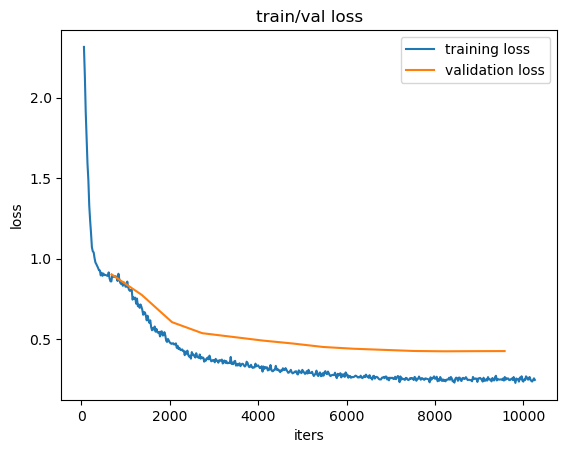

In [14]:
plt.plot(train_iters, train_loss)
plt.plot(val_iters, val_loss)
plt.xlabel("iters")
plt.ylabel("loss")
plt.title("train/val loss")
plt.legend(["training loss", "validation loss"], loc="upper right")
plt.show()

### Evalatuate Model on Mixed Testset

Using Default Predictor with Threshold of 0.7

In [15]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/27 01:34:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./models/recovery_resnet/model_best.pth ...


In [16]:
evaluator = COCOEvaluator(
    dataset_name="mixed_test",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "inference", "mixed"),
    allow_cached_coco=False,
    max_dets_per_image=1000,
    use_fast_impl=False,
)
testloader = build_detection_test_loader(cfg, "mixed_test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

[02/27 01:34:55 d2.evaluation.coco_evaluation]: Trying to convert 'mixed_test' to COCO format ...
[02/27 01:34:55 d2.data.datasets.coco]: Converting annotations of dataset 'mixed_test' to COCO format ...)


registering mixed dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1769/1769 [00:34<00:00, 51.87it/s]

[02/27 01:35:30 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[02/27 01:35:30 d2.data.datasets.coco]: Conversion finished, #images: 1769, #annotations: 5289
[02/27 01:35:30 d2.data.datasets.coco]: Caching COCO format annotations at './models/recovery_resnet/inference/mixed/mixed_test_coco_format.json' ...


registering mixed dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1769/1769 [00:33<00:00, 52.51it/s]

[02/27 01:36:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/27 01:36:05 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 01:36:05 d2.data.common]: Serializing 1769 elements to byte tensors and concatenating them all ...


[02/27 01:36:07 d2.data.common]: Serialized dataset takes 22.09 MiB
[02/27 01:36:07 d2.evaluation.evaluator]: Start inference on 1769 batches
[02/27 01:36:08 d2.evaluation.evaluator]: Inference done 11/1769. Dataloading: 0.0011 s/iter. Inference: 0.0347 s/iter. Eval: 0.0072 s/iter. Total: 0.0430 s/iter. ETA=0:01:15
[02/27 01:36:13 d2.evaluation.evaluator]: Inference done 113/1769. Dataloading: 0.0037 s/iter. Inference: 0.0385 s/iter. Eval: 0.0065 s/iter. Total: 0.0487 s/iter. ETA=0:01:20
[02/27 01:36:18 d2.evaluation.evaluator]: Inference done 243/1769. Dataloading: 0.0024 s/iter. Inference: 0.0364 s/iter. Eval: 0.0043 s/iter. Total: 0.0432 s/iter. ETA=0:01:05
[02/27 01:36:23 d2.evaluation.evaluator]: Inference done 374/1769. Dataloading: 0.0019 s/iter. Inference: 0.0356 s/iter. Eval: 0.0038 s/iter. Total: 0.0415 s/iter. ETA=0:00:57
[02/27 01:36:28 d2.evaluation.evaluator]: Inference done 502/1769. Dataloading: 0.0017 s/iter. Inference: 0.0352 s/iter. Eval: 0.0039 s/iter. Total: 0.0409

### Visualize Inference on Mixed Testset

In [17]:
def visualize_inference(dataset_name: str, k: int):
    testset = get_detection_dataset_dicts(dataset_name, filter_empty=False)
    for d in random.sample(testset, k):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(
            img[:, :, ::-1],
            metadata=MetadataCatalog.get(dataset_name),
            scale=1.0,
            instance_mode=ColorMode.SEGMENTATION,
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.imshow(out.get_image())
        plt.axis("off")
        plt.show()

registering mixed dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1769/1769 [00:33<00:00, 52.51it/s]


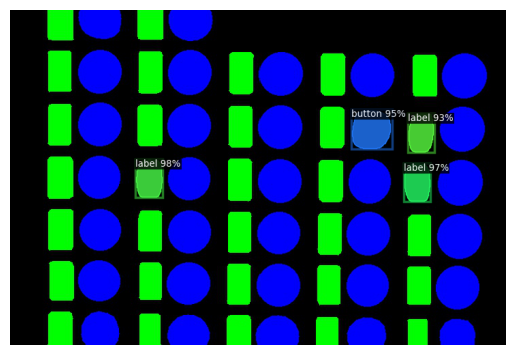

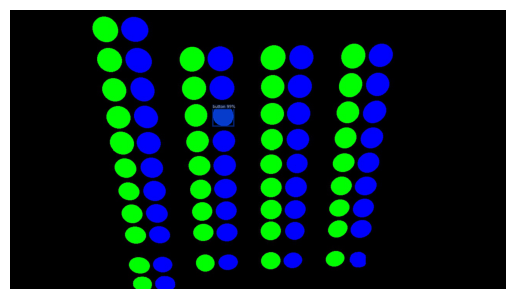

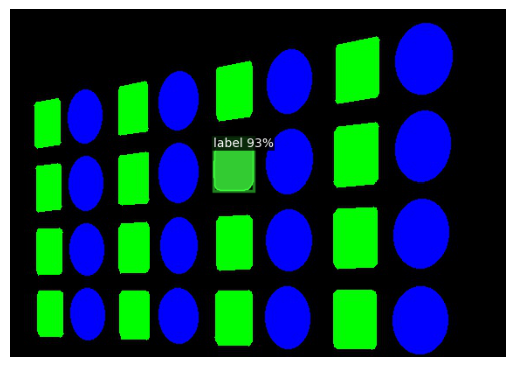

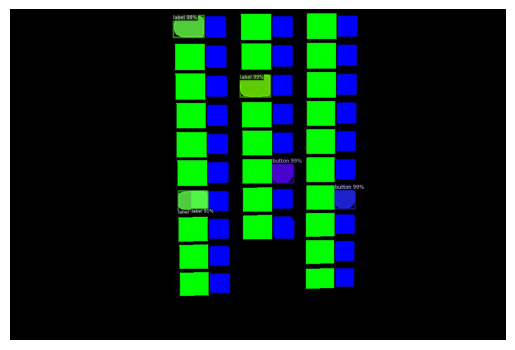

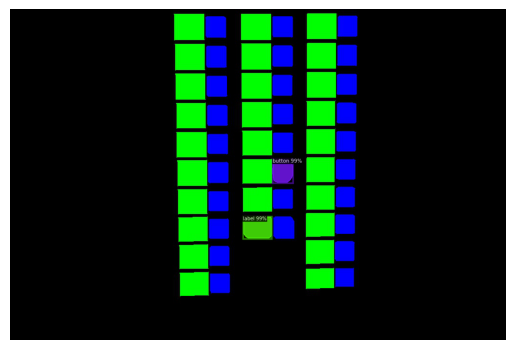

In [18]:
visualize_inference("mixed_test", 5)

### Evaluate Model on UT-West-Campus Testset

In [19]:
evaluator = COCOEvaluator(
    dataset_name="ut_west_campus_test",
    output_dir=os.path.join(cfg.OUTPUT_DIR, "inference", "ut_west_campus"),
    allow_cached_coco=False,
    use_fast_impl=False,
)
testloader = build_detection_test_loader(cfg, "ut_west_campus_test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

[02/27 01:38:26 d2.evaluation.coco_evaluation]: Trying to convert 'ut_west_campus_test' to COCO format ...
[02/27 01:38:26 d2.data.datasets.coco]: Converting annotations of dataset 'ut_west_campus_test' to COCO format ...)


registering ut_west_campus dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 3242/3242 [05:27<00:00,  9.88it/s]

[02/27 01:43:54 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[02/27 01:43:54 d2.data.datasets.coco]: Conversion finished, #images: 3242, #annotations: 5630
[02/27 01:43:54 d2.data.datasets.coco]: Caching COCO format annotations at './models/recovery_resnet/inference/ut_west_campus/ut_west_campus_test_coco_format.json' ...


registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3242/3242 [06:40<00:00,  8.10it/s]

[02/27 01:50:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/27 01:50:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 01:50:40 d2.data.common]: Serializing 3242 elements to byte tensors and concatenating them all ...


[02/27 01:50:46 d2.data.common]: Serialized dataset takes 90.92 MiB
[02/27 01:50:46 d2.evaluation.evaluator]: Start inference on 3242 batches
[02/27 01:50:48 d2.evaluation.evaluator]: Inference done 11/3242. Dataloading: 0.0440 s/iter. Inference: 0.0389 s/iter. Eval: 0.0293 s/iter. Total: 0.1122 s/iter. ETA=0:06:02
[02/27 01:50:53 d2.evaluation.evaluator]: Inference done 43/3242. Dataloading: 0.0581 s/iter. Inference: 0.0388 s/iter. Eval: 0.0534 s/iter. Total: 0.1504 s/iter. ETA=0:08:01
[02/27 01:50:58 d2.evaluation.evaluator]: Inference done 78/3242. Dataloading: 0.0568 s/iter. Inference: 0.0401 s/iter. Eval: 0.0506 s/iter. Total: 0.1476 s/iter. ETA=0:07:47
[02/27 01:51:03 d2.evaluation.evaluator]: Inference done 112/3242. Dataloading: 0.0547 s/iter. Inference: 0.0394 s/iter. Eval: 0.0547 s/iter. Total: 0.1490 s/iter. ETA=0:07:46
[02/27 01:51:08 d2.evaluation.evaluator]: Inference done 145/3242. Dataloading: 0.0522 s/iter. Inference: 0.0394 s/iter. Eval: 0.0581 s/iter. Total: 0.1498 s

### Visualize Inference on UT-West-Campus Testset

registering ut_west_campus dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3242/3242 [05:05<00:00, 10.60it/s]


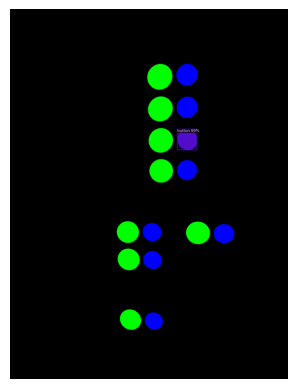

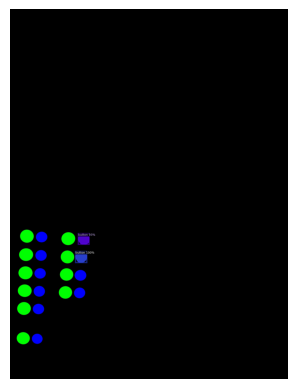

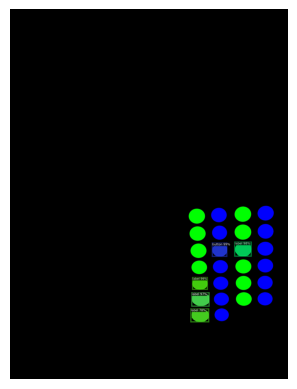

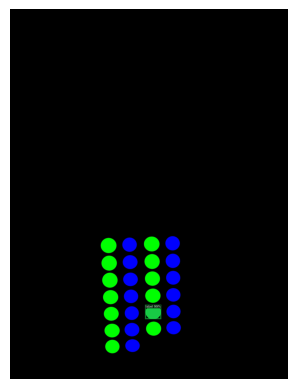

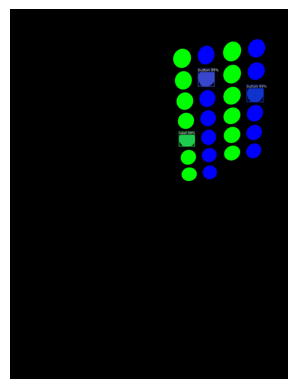

In [20]:
visualize_inference("ut_west_campus_test", 5)